In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

Matplotlib is building the font cache; this may take a moment.


In [2]:
def exponential(x, r):
    return x * r

In [3]:
def logical(x, r):
    return r * x * (1 - x)

In [4]:
def moran(x, r):
    return x * math.exp(r * (1 - x))

In [5]:
def parasit(x, y, a, b, c):
    x_new = b * x * math.exp(-a * y)
    y_new = c * x * (1 - math.exp(-a * y))
    return x_new, y_new

In [6]:
def exponential_model(x, r, num_steps):
    results = np.zeros(num_steps)
    results[0] = x

    for i in range(1, num_steps):
        x = exponential(x, r)
        results[i] = x

    return results

In [7]:
def logical_model(x, r, num_steps):
    results = np.zeros(num_steps)
    results[0] = x

    for i in range(1, num_steps):
        x = logical(x, r)
        results[i] = x;

    return results

In [8]:
def moran_model(x, r, num_steps):
    results = np.zeros(num_steps)
    results[0] = x

    for i in range(1, num_steps):
        x = moran(x, r)
        results[i] = x;

    return results

In [9]:
def parasit_model(x, y, num_steps, a, b, c):
    results_x = np.zeros(num_steps)
    results_x[0] = x

    results_y = np.zeros(num_steps)
    results_y[0] = y

    for i in range(1, num_steps):
        x, y = parasit(x, y, a, b, c)
        results_x[i] = x
        results_y[i] = y

    return results_x, results_y

In [11]:
def classify_behavior(results):
    steady_state = results[int(0.8 * len(results)):]
    
    if len(steady_state) < 10:
        return "Недостаточно данных"
    
    mean_val = np.mean(steady_state)
    std_val = np.std(steady_state)
    max_val = np.max(results)
    
    if (max_val > 1e10 or
        (results[-1] > 1e6 and results[-1] > 10 * results[0]) or
        np.any(np.isnan(results)) or
        np.any(results > 1e15)):
        return "Неконтролируемый рост"
    
    if mean_val < 1e-10:
        return "Вымирание"
    
    if std_val < 0.001:
        return "Стабильное равновесие"
    
    if len(steady_state) > 1:
        autocorr = np.corrcoef(steady_state[:-1], steady_state[1:])[0,1]
    else:
        autocorr = 0
    
    if std_val < 0.1:
        return "Слабые колебания"
    elif autocorr > 0.7:
        return "Периодические колебания"
    elif (np.max(steady_state) - np.min(steady_state)) > 0.5 * mean_val:
        return "Хаотические колебания"
    else:
        return "Сложное поведение"

In [12]:
def classify_behavior_host_parasite(hosts, parasites):
    steady_hosts = hosts[int(0.8 * len(hosts)):]
    steady_parasites = parasites[int(0.8 * len(parasites)):]
    
    mean_hosts = np.mean(steady_hosts)
    mean_parasites = np.mean(steady_parasites)
    
    if mean_hosts < 1e-10:
        return "Вымирание хозяев"
    if mean_parasites < 1e-10:
        return "Вымирание паразитов"
    
    std_hosts = np.std(steady_hosts)
    std_parasites = np.std(steady_parasites)
    
    if std_hosts < 0.01 and std_parasites < 0.01:
        return "Стабильное сосуществование"
    
    correlation = np.corrcoef(steady_hosts, steady_parasites)[0,1]
    
    if correlation < -0.5:
        return "Антифазные колебания"
    elif std_hosts > 0.5 * mean_hosts or std_parasites > 0.5 * mean_parasites:
        return "Сильные колебания"
    else:
        return "Умеренные колебания"

In [20]:
def investigate_initial_conditions(model_func, model_name, param_name, param_value, 
                                 initial_conditions, num_steps=500, **fixed_params):
    print(f"\n{'='*60}")
    print(f"ВЛИЯНИЕ НАЧАЛЬНЫХ УСЛОВИЙ: {model_name} ({param_name}={param_value})")
    if fixed_params:
        print(f"Фиксированные параметры: {fixed_params}")
    print(f"{'='*60}")
    
    for x0 in initial_conditions:
        if model_name == "Хозяин-Паразит":
            a = fixed_params.get('a', param_value if param_name == 'a' else 0.1)
            b = fixed_params.get('b', param_value if param_name == 'b' else 1.5)  
            c = fixed_params.get('c', param_value if param_name == 'c' else 1.0)
            
            results_x, results_y = model_func(x0, x0*0.1, num_steps, a, b, c)
            final_x = results_x[-1]
            final_y = results_y[-1]
            behavior = classify_behavior_host_parasite(results_x, results_y)
            
            print(f"x0={x0:.1f}: Хозяева={final_x:.4f}, Паразиты={final_y:.4f} → {behavior}")
            
        else:
            results = model_func(x0, param_value, num_steps)
            final_value = results[-1]
            behavior = classify_behavior(results)
            print(f"x0={x0:.3f}: Финальное значение={final_value:.4f} → {behavior}")

In [21]:
print("ПОЛНОЕ ИССЛЕДОВАНИЕ МОДЕЛЕЙ ПОПУЛЯЦИЙ")
print("=" * 70)

# Диапазоны начальных условий
initial_conditions_range = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.5, 2.0]

# 1. Экспоненциальная модель с разными r
print("\n1. ЭКСПОНЕНЦИАЛЬНАЯ МОДЕЛЬ")
r_values_exp = [0.5, 1.0, 1.5, 2.0]
for r in r_values_exp:
    investigate_initial_conditions(
        exponential_model, "Экспоненциальный рост", "r", r, 
        initial_conditions_range
    )

# 2. Логистическая модель с разными r
print("\n2. ЛОГИСТИЧЕСКАЯ МОДЕЛЬ")
r_values_log = [2.0, 2.8, 3.2, 3.5, 3.8, 4.0]
for r in r_values_log:
    investigate_initial_conditions(
        logical_model, "Логистическая модель", "r", r,
        initial_conditions_range
    )

# 3. Модель Морана с разными r
print("\n3. МОДЕЛЬ МОРАНА")
r_values_moran = [1.5, 2.0, 2.5, 3.0]
for r in r_values_moran:
    investigate_initial_conditions(
        moran_model, "Модель Морана", "r", r,
        initial_conditions_range
    )

# 4. Модель Хозяин-Паразит с разными параметрами
print("\n4. МОДЕЛЬ ХОЗЯИН-ПАРАЗИТ")

# Параметры для полного исследования
a_values = [0.05, 0.1, 0.2, 0.3]      # Эффективность заражения
b_values = [1.2, 1.5, 2.0, 2.5]       # Скорость размножения хозяев  
c_values = [0.5, 1.0, 1.5, 2.0]       # Скорость размножения паразитов
initial_hosts = [0.5, 1.0, 2.0, 5.0]  # Начальные популяции хозяев

# Исследуем разные комбинации параметров
print("Исследование параметра a (эффективность заражения):")
for a in a_values:
    # Фиксируем b и c для исследования a
    b_fixed, c_fixed = 1.5, 1.0
    investigate_initial_conditions(
        parasit_model, "Хозяин-Паразит", "a", a,
        initial_hosts, b=b_fixed, c=c_fixed
    )

print("\nИсследование параметра b (размножение хозяев):")
for b in b_values:
    # Фиксируем a и c для исследования b
    a_fixed, c_fixed = 0.1, 1.0
    investigate_initial_conditions(
        parasit_model, "Хозяин-Паразит", "b", b,
        initial_hosts, a=a_fixed, c=c_fixed
    )

print("\nИсследование параметра c (размножение паразитов):")
for c in c_values:
    # Фиксируем a и b для исследования c
    a_fixed, b_fixed = 0.1, 1.5
    investigate_initial_conditions(
        parasit_model, "Хозяин-Паразит", "c", c,
        initial_hosts, a=a_fixed, b=b_fixed
    )

ПОЛНОЕ ИССЛЕДОВАНИЕ МОДЕЛЕЙ ПОПУЛЯЦИЙ

1. ЭКСПОНЕНЦИАЛЬНАЯ МОДЕЛЬ

ВЛИЯНИЕ НАЧАЛЬНЫХ УСЛОВИЙ: Экспоненциальный рост (r=0.5)
x0=0.010: Финальное значение=0.0000 → Вымирание
x0=0.100: Финальное значение=0.0000 → Вымирание
x0=0.300: Финальное значение=0.0000 → Вымирание
x0=0.500: Финальное значение=0.0000 → Вымирание
x0=0.700: Финальное значение=0.0000 → Вымирание
x0=0.900: Финальное значение=0.0000 → Вымирание
x0=1.000: Финальное значение=0.0000 → Вымирание
x0=1.500: Финальное значение=0.0000 → Вымирание
x0=2.000: Финальное значение=0.0000 → Вымирание

ВЛИЯНИЕ НАЧАЛЬНЫХ УСЛОВИЙ: Экспоненциальный рост (r=1.0)
x0=0.010: Финальное значение=0.0100 → Стабильное равновесие
x0=0.100: Финальное значение=0.1000 → Стабильное равновесие
x0=0.300: Финальное значение=0.3000 → Стабильное равновесие
x0=0.500: Финальное значение=0.5000 → Стабильное равновесие
x0=0.700: Финальное значение=0.7000 → Стабильное равновесие
x0=0.900: Финальное значение=0.9000 → Стабильное равновесие
x0=1.000: Финальное значен

In [25]:
def find_critical_parasite_params():
    print("\nПОИСК КРИТИЧЕСКИХ ПАРАМЕТРОВ:")
    
    a_range = np.linspace(0.01, 0.5, 50)
    critical_a = []
    prev_behavior = None
    
    for a in a_range:
        hosts, parasites = parasit_model(1.0, 0.1, 300, a, 1.5, 1.0)
        behavior = classify_behavior_host_parasite(hosts, parasites)
        
        if prev_behavior and behavior != prev_behavior:
            critical_a.append((a, f"{prev_behavior} → {behavior}"))
        
        prev_behavior = behavior
    
    b_range = np.linspace(1.0, 3.0, 50)
    critical_b = []
    prev_behavior = None
    
    for b in b_range:
        hosts, parasites = parasit_model(1.0, 0.1, 300, 0.1, b, 1.0)
        behavior = classify_behavior_host_parasite(hosts, parasites)
        
        if prev_behavior and behavior != prev_behavior:
            critical_b.append((b, f"{prev_behavior} → {behavior}"))
        
        prev_behavior = behavior
    
    c_range = np.linspace(0.1, 3.0, 50)
    critical_c = []
    prev_behavior = None
    
    for c in c_range:
        hosts, parasites = parasit_model(1.0, 0.1, 300, 0.1, 1.5, c)
        behavior = classify_behavior_host_parasite(hosts, parasites)
        
        if prev_behavior and behavior != prev_behavior:
            critical_c.append((c, f"{prev_behavior} → {behavior}"))
        
        prev_behavior = behavior
    
    print("\nКритические значения параметра a (эффективность заражения):")
    for a_val, change in critical_a:
        print(f"  a ≈ {a_val:.3f}: {change}")
    
    print("\nКритические значения параметра b (размножение хозяев):")
    for b_val, change in critical_b:
        print(f"  b ≈ {b_val:.3f}: {change}")
    
    print("\nКритические значения параметра c (размножение паразитов):")
    for c_val, change in critical_c:
        print(f"  c ≈ {c_val:.3f}: {change}")

find_critical_parasite_params()


ПОИСК КРИТИЧЕСКИХ ПАРАМЕТРОВ:

Критические значения параметра a (эффективность заражения):
  a ≈ 0.030: Вымирание хозяев → Вымирание паразитов
  a ≈ 0.480: Вымирание паразитов → Вымирание хозяев

Критические значения параметра b (размножение хозяев):

Критические значения параметра c (размножение паразитов):
  c ≈ 0.218: Вымирание хозяев → Вымирание паразитов


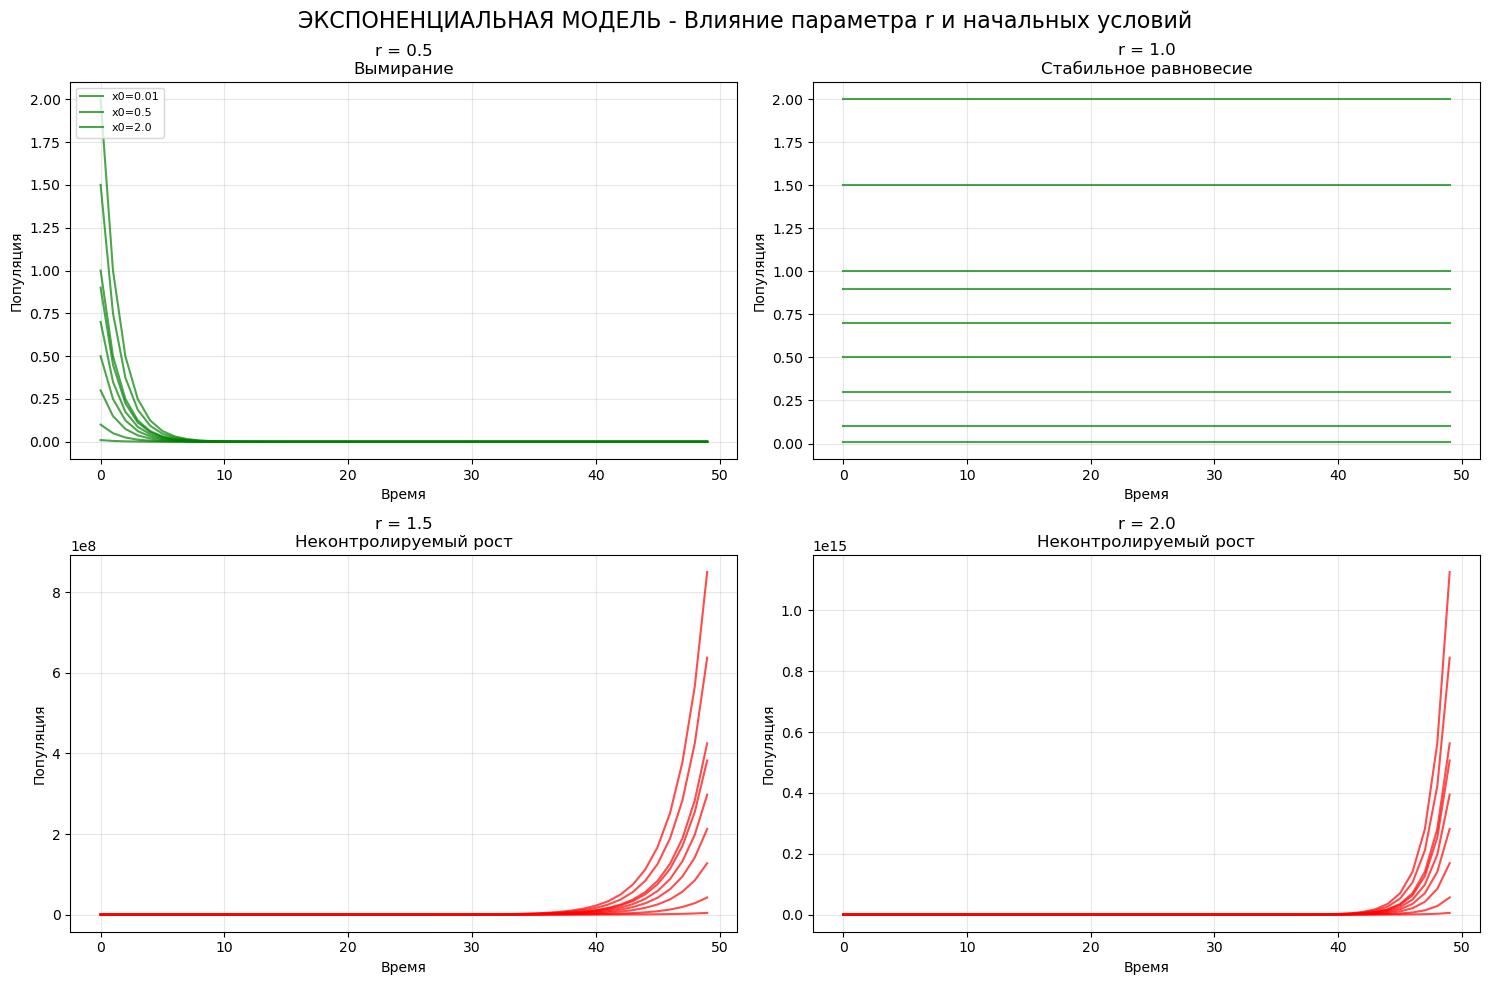

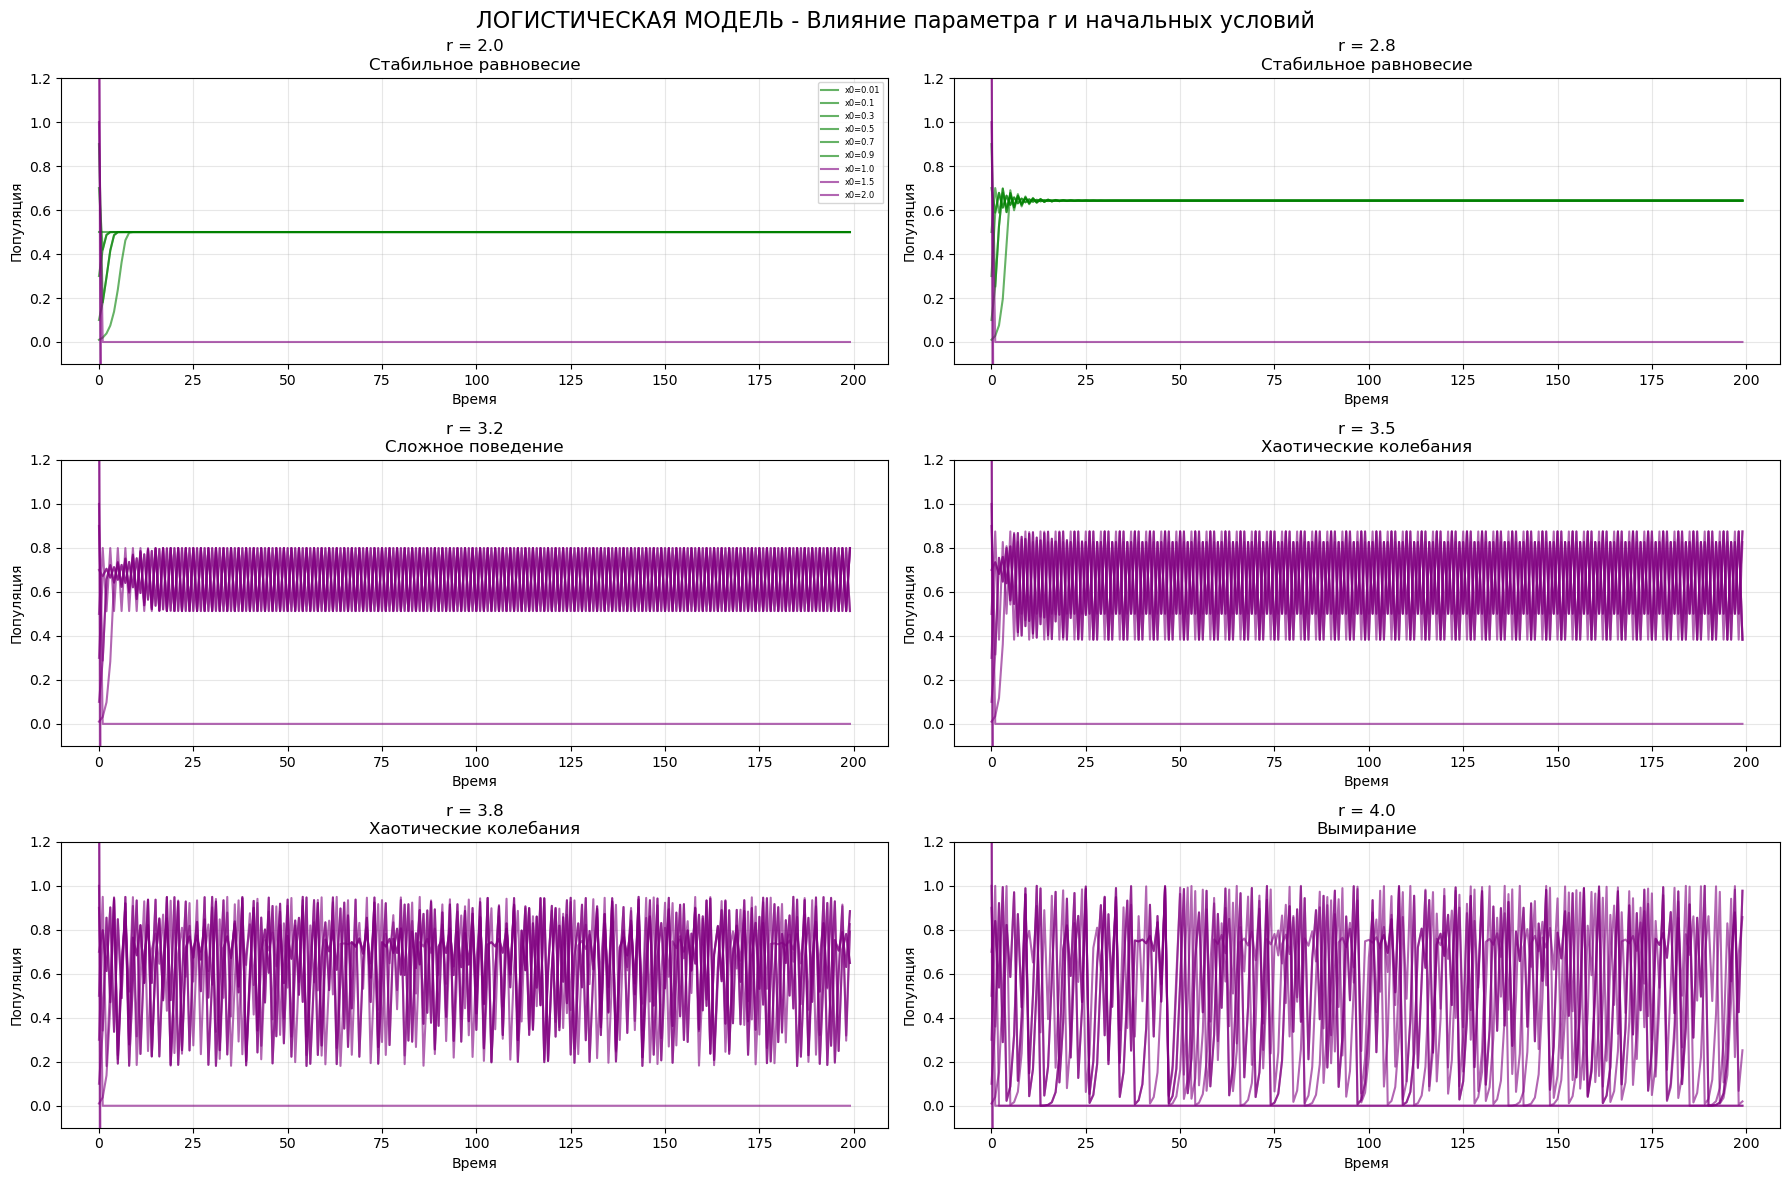

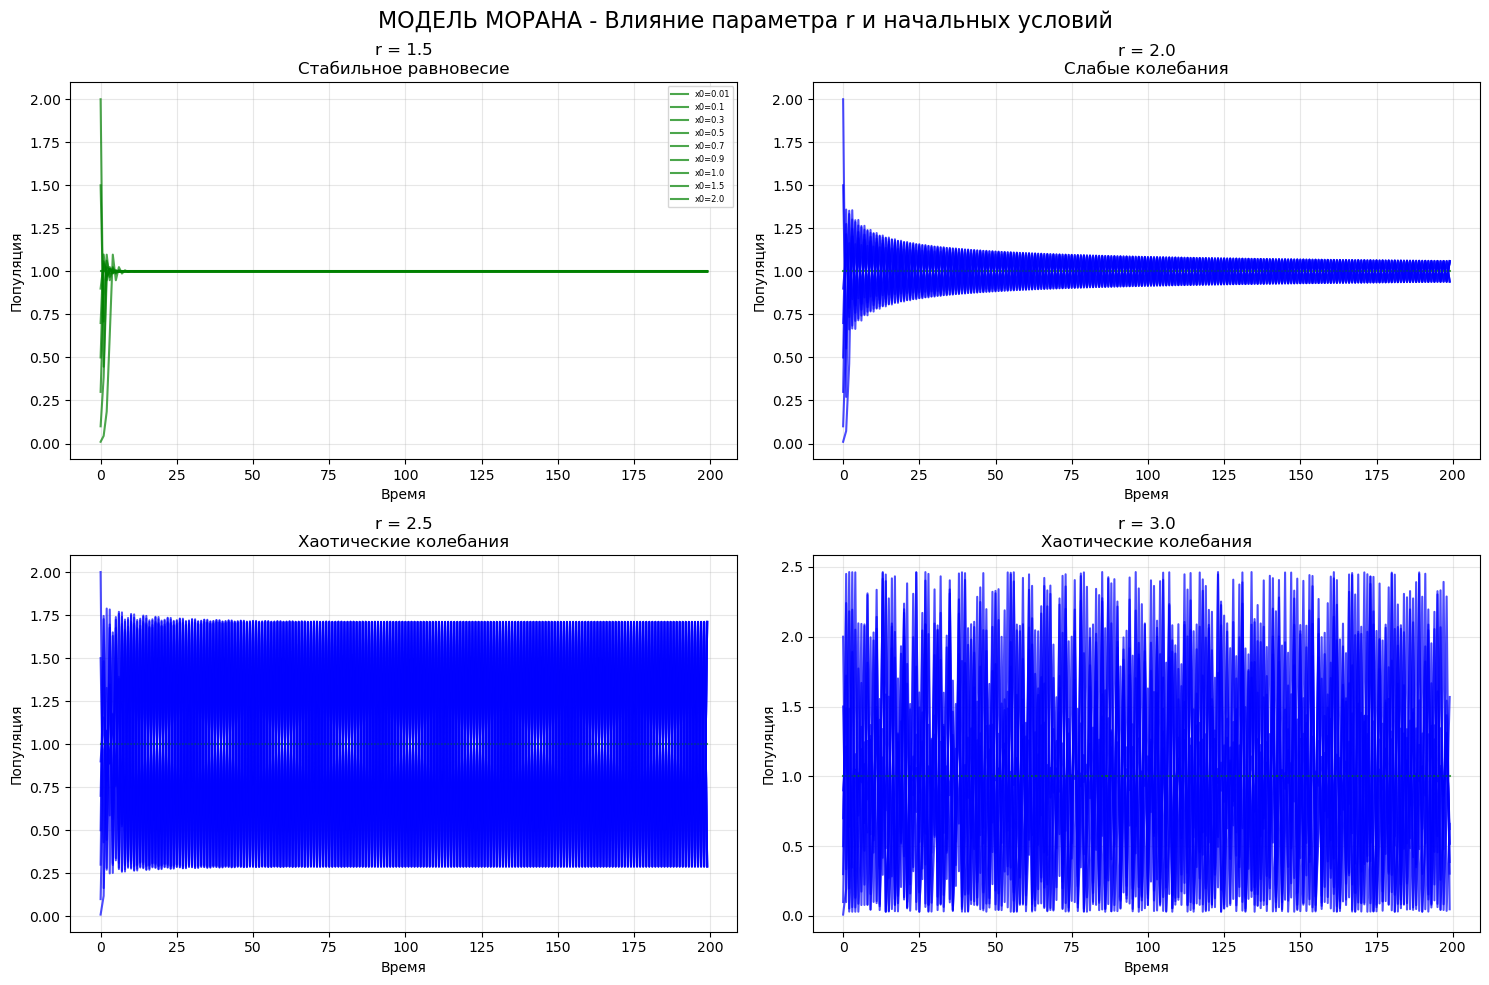

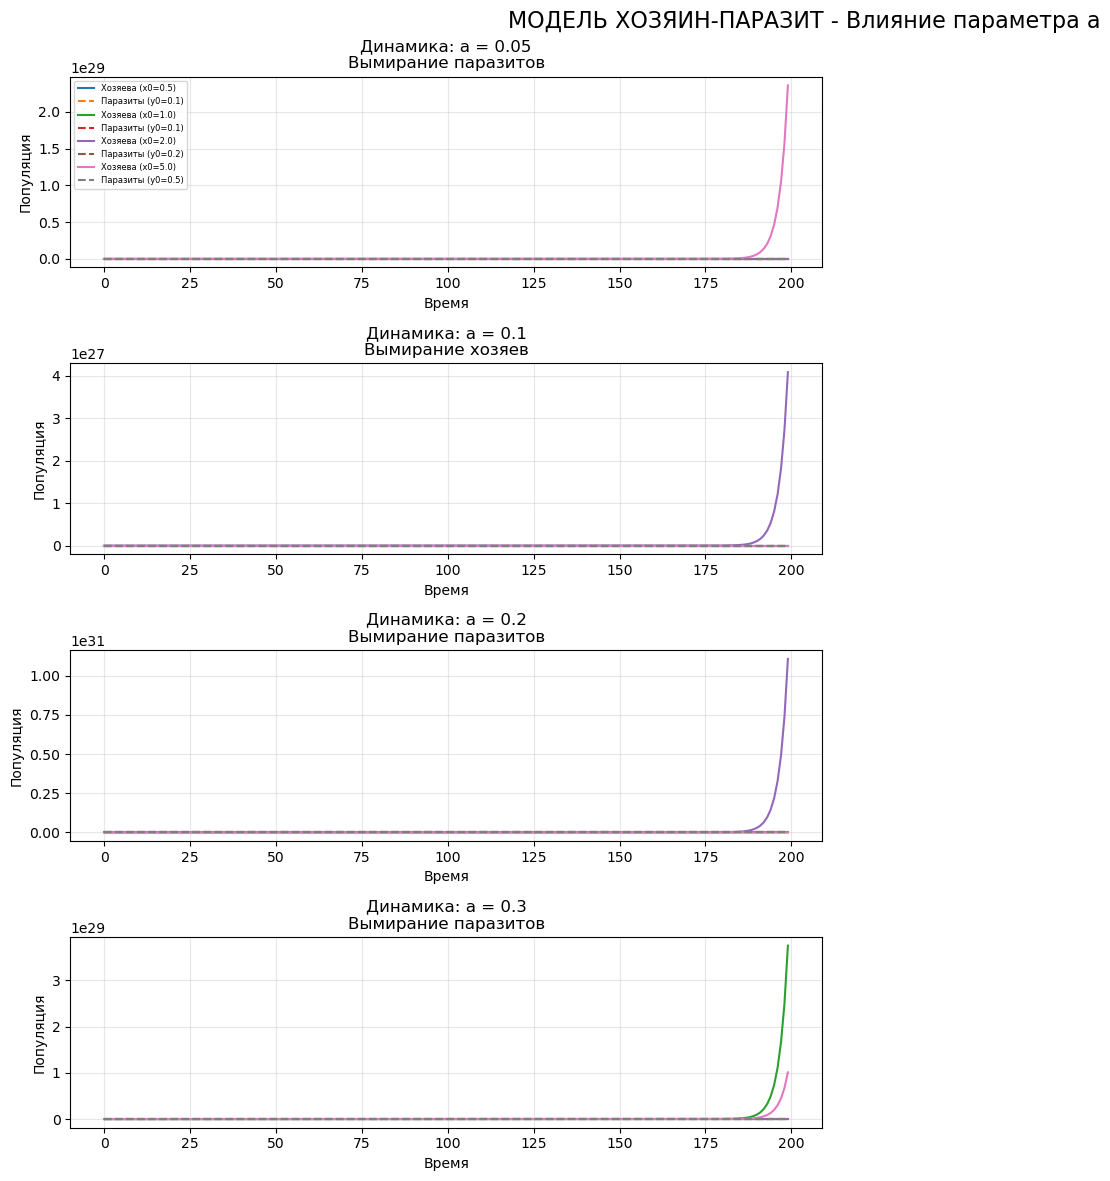

In [27]:
# 1. ЭКСПОНЕНЦИАЛЬНАЯ МОДЕЛЬ
plt.figure(figsize=(15, 10))
plt.suptitle('ЭКСПОНЕНЦИАЛЬНАЯ МОДЕЛЬ - Влияние параметра r и начальных условий', fontsize=16, y=0.98)

for i, r in enumerate(r_values_exp):
    plt.subplot(2, 2, i+1)
    
    for x0 in initial_conditions_range:
        results = exponential_model(x0, r, 50)
        behavior = classify_behavior(results)
        
        if 'рост' in behavior:
            color = 'red'
            linestyle = '-'
        elif 'вымирание' in behavior:
            color = 'blue'
            linestyle = '--'
        else:
            color = 'green'
            linestyle = '-'
            
        plt.plot(results, color=color, linestyle=linestyle, alpha=0.7, 
                label=f'x0={x0}' if x0 in [0.01, 0.5, 2.0] else "")  # Показываем только некоторые легенды
    
    plt.title(f'r = {r}\n{classify_behavior(exponential_model(0.5, r, 50))}')
    plt.xlabel('Время')
    plt.ylabel('Популяция')
    plt.grid(True, alpha=0.3)
    if i == 0:
        plt.legend(fontsize=8, loc='upper left')

plt.tight_layout()
plt.show()

# 2. ЛОГИСТИЧЕСКАЯ МОДЕЛЬ
plt.figure(figsize=(18, 12))
plt.suptitle('ЛОГИСТИЧЕСКАЯ МОДЕЛЬ - Влияние параметра r и начальных условий', fontsize=16, y=0.98)

for i, r in enumerate(r_values_log):
    plt.subplot(3, 2, i+1)
    
    for x0 in initial_conditions_range:
        results = logical_model(x0, r, 200)
        behavior = classify_behavior(results)
        
        if 'Стабиль' in behavior:
            color = 'green'
            linestyle = '-'
        elif 'Колебания' in behavior:
            color = 'orange'
            linestyle = '-'
        elif 'Хаос' in behavior:
            color = 'red'
            linestyle = '-'
        elif 'вымирание' in behavior:
            color = 'blue'
            linestyle = '--'
        else:
            color = 'purple'
            linestyle = '-'
            
        plt.plot(results, color=color, linestyle=linestyle, alpha=0.6, 
                label=f'x0={x0}')
    
    final_behavior = classify_behavior(logical_model(0.5, r, 200))
    plt.title(f'r = {r}\n{final_behavior}')
    plt.xlabel('Время')
    plt.ylabel('Популяция')
    plt.ylim(-0.1, 1.2)
    plt.grid(True, alpha=0.3)
    if i == 0:  # Легенду только для первого графика
        plt.legend(fontsize=6, loc='upper right')

plt.tight_layout()
plt.show()

# 3. МОДЕЛЬ МОРАНА
plt.figure(figsize=(15, 10))
plt.suptitle('МОДЕЛЬ МОРАНА - Влияние параметра r и начальных условий', fontsize=16, y=0.98)

for i, r in enumerate(r_values_moran):
    plt.subplot(2, 2, i+1)
    
    for x0 in initial_conditions_range:
        results = moran_model(x0, r, 200)
        behavior = classify_behavior(results)
        
        if 'Стабиль' in behavior:
            color = 'green'
        elif 'Колебания' in behavior:
            color = 'orange'
        elif 'Хаос' in behavior:
            color = 'red'
        else:
            color = 'blue'
            
        plt.plot(results, color=color, alpha=0.7, label=f'x0={x0}')
    
    final_behavior = classify_behavior(moran_model(0.5, r, 200))
    plt.title(f'r = {r}\n{final_behavior}')
    plt.xlabel('Время')
    plt.ylabel('Популяция')
    plt.grid(True, alpha=0.3)
    if i == 0:
        plt.legend(fontsize=6, loc='upper right')

plt.tight_layout()
plt.show()

# 4. МОДЕЛЬ ХОЗЯИН-ПАРАЗИТ
plt.figure(figsize=(16, 12))
plt.suptitle('МОДЕЛЬ ХОЗЯИН-ПАРАЗИТ - Влияние параметра a', fontsize=16, y=0.98)

x0_values_parasite = [0.5, 1.0, 2.0, 5.0]

for i, a in enumerate(a_values):
    plt.subplot(4, 2, 2*i+1)
    
    for x0 in x0_values_parasite:
        hosts, parasites = parasit_model(x0, x0*0.1, 200, a, 1.5, 1.0)
        plt.plot(hosts, label=f'Хозяева (x0={x0})', linewidth=1.5)
        plt.plot(parasites, label=f'Паразиты (y0={x0*0.1:.1f})', linewidth=1.5, linestyle='--')
    
    behavior = classify_behavior_host_parasite(hosts, parasites)
    plt.title(f'Динамика: a = {a}\n{behavior}')
    plt.xlabel('Время')
    plt.ylabel('Популяция')
    plt.grid(True, alpha=0.3)
    if i == 0:
        plt.legend(fontsize=6)

plt.tight_layout()
plt.show()

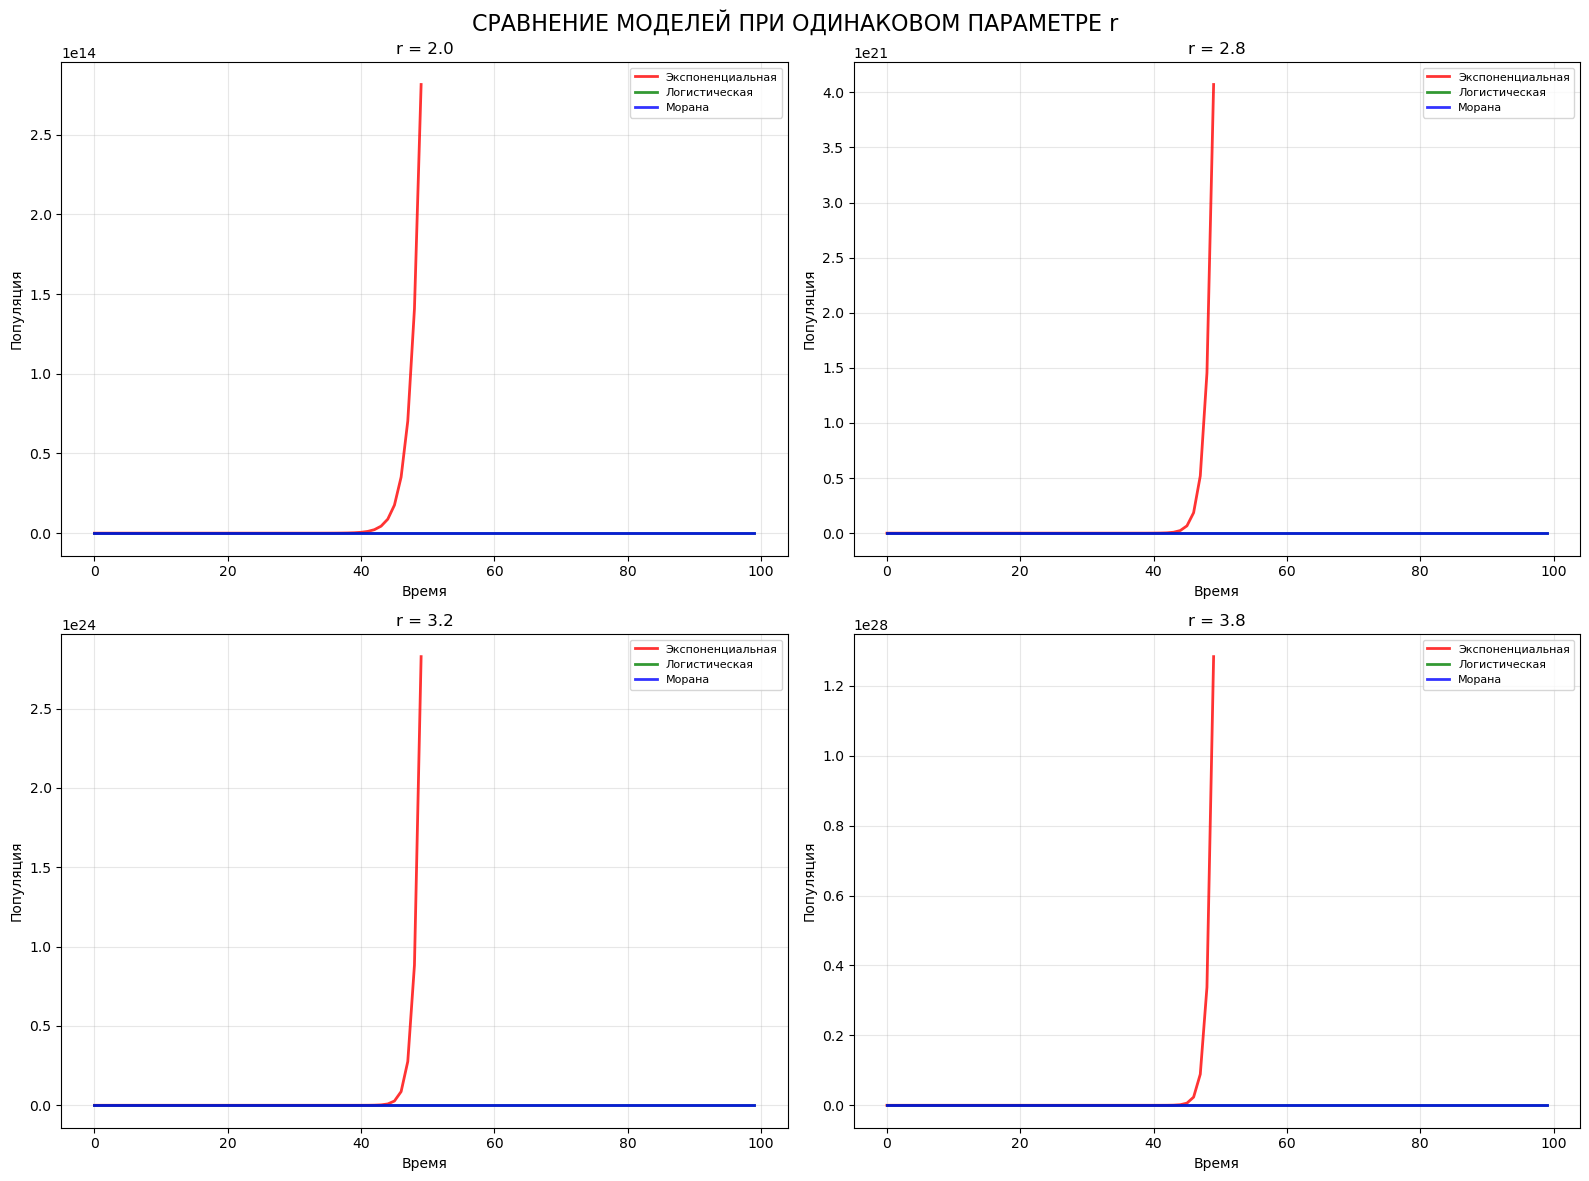

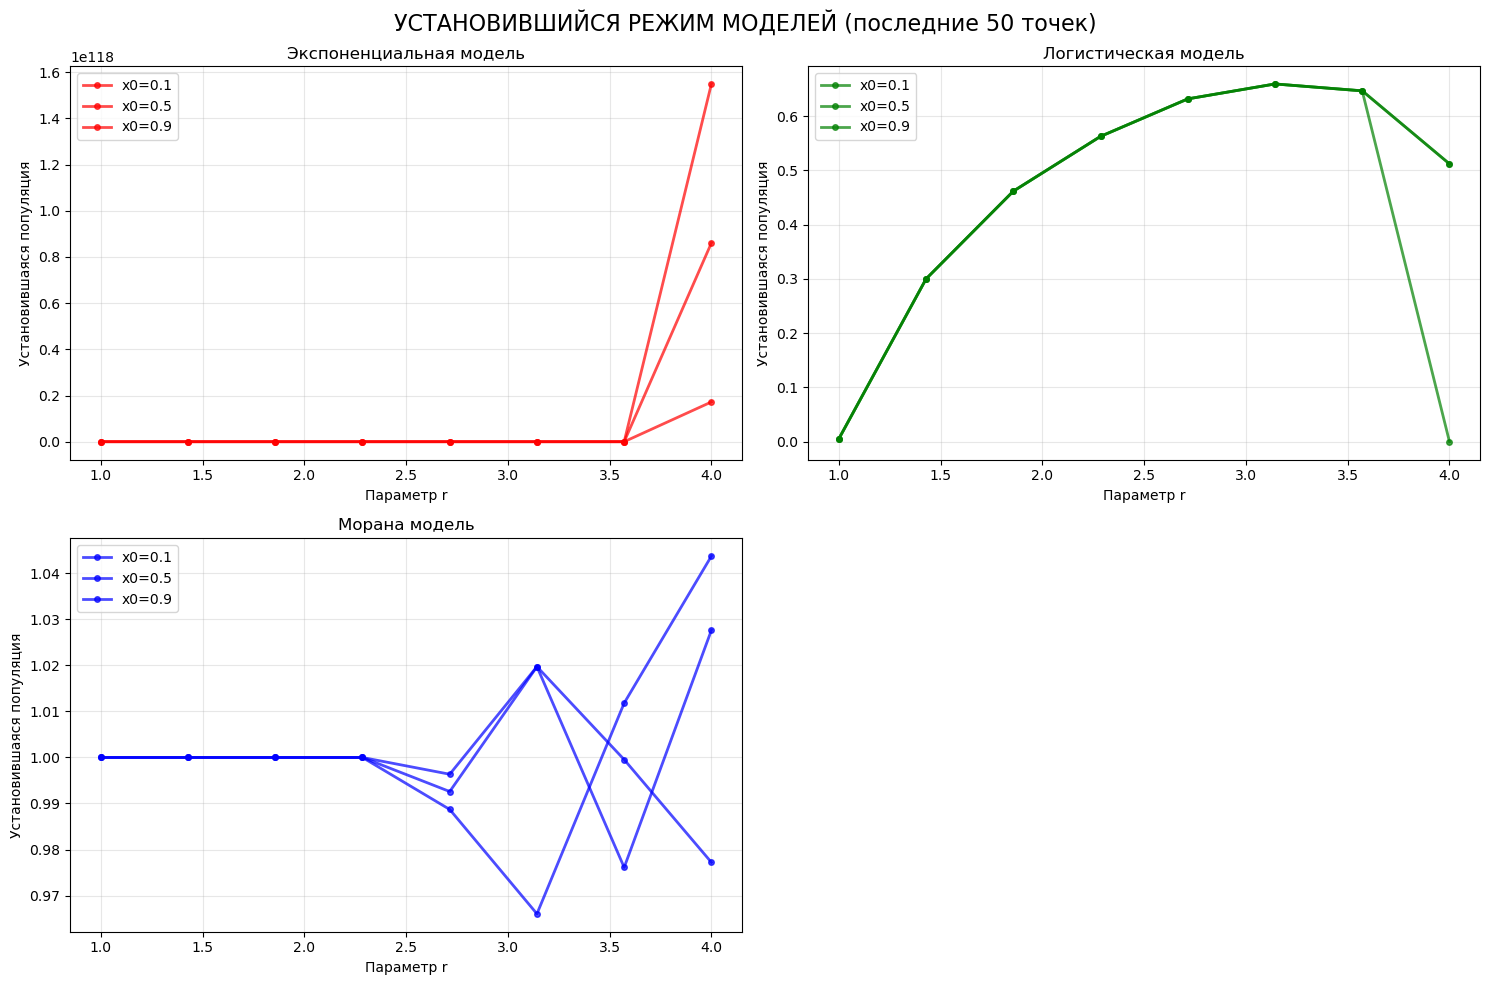

In [18]:
# СРАВНЕНИЕ ПОВЕДЕНИЯ ВСЕХ МОДЕЛЕЙ ПРИ ОДИНАКОВЫХ r
plt.figure(figsize=(16, 12))
plt.suptitle('СРАВНЕНИЕ МОДЕЛЕЙ ПРИ ОДИНАКОВОМ ПАРАМЕТРЕ r', fontsize=16, y=0.98)

test_r_values = [2.0, 2.8, 3.2, 3.8]
x0_test = 0.5

for i, r in enumerate(test_r_values):
    plt.subplot(2, 2, i+1)
    
    # Экспоненциальная
    results_exp = exponential_model(x0_test, r, 50)
    plt.plot(results_exp[:50], 'r-', label='Экспоненциальная', linewidth=2, alpha=0.8)
    
    # Логистическая
    results_log = logical_model(x0_test, r, 100)
    plt.plot(results_log, 'g-', label='Логистическая', linewidth=2, alpha=0.8)
    
    # Морана
    results_moran = moran_model(x0_test, r, 100)
    plt.plot(results_moran, 'b-', label='Морана', linewidth=2, alpha=0.8)
    
    plt.title(f'r = {r}')
    plt.xlabel('Время')
    plt.ylabel('Популяция')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

# ГРАФИКИ УСТАНОВИВШЕГОСЯ РЕЖИМА
plt.figure(figsize=(15, 10))
plt.suptitle('УСТАНОВИВШИЙСЯ РЕЖИМ МОДЕЛЕЙ (последние 50 точек)', fontsize=16, y=0.98)

models = [
    (exponential_model, 'Экспоненциальная', 'red'),
    (logical_model, 'Логистическая', 'green'), 
    (moran_model, 'Морана', 'blue')
]

r_test_range = np.linspace(1.0, 4.0, 8)

for i, (model_func, model_name, color) in enumerate(models):
    plt.subplot(2, 2, i+1)
    
    for x0 in [0.1, 0.5, 0.9]:
        final_values = []
        for r in r_test_range:
            results = model_func(x0, r, 200)
            steady_mean = np.mean(results[150:])
            final_values.append(steady_mean)
        
        plt.plot(r_test_range, final_values, 'o-', color=color, alpha=0.7, 
                label=f'x0={x0}', linewidth=2, markersize=4)
    
    plt.title(f'{model_name} модель')
    plt.xlabel('Параметр r')
    plt.ylabel('Установившаяся популяция')
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()